In [1]:
from PIL import Image, ImageDraw, ImageFont
import os

def add_massive_watermark(
    input_path,
    output_path=None,
    text="DeepExPo (Synthetic)",
    opacity=230,
    margin_ratio=0.02,
    font_size=None   # If None, auto-scale
):
    # Open image
    base = Image.open(input_path)
    base_rgba = base.convert("RGBA")
    width, height = base_rgba.size

    overlay = Image.new("RGBA", (width, height), (0,0,0,0))
    draw = ImageDraw.Draw(overlay)

    # Auto font size
    if font_size is None:
        font_size = int(width * 0.05)  # smaller to avoid kernel crash

    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    bbox = draw.textbbox((0,0), text, font=font)
    text_width = bbox[2]-bbox[0]
    text_height = bbox[3]-bbox[1]

    margin = int(width * margin_ratio)
    x = margin
    y = height - text_height - margin

    shadow_offset = max(2, int(font_size*0.02))
    draw.text((x+shadow_offset, y+shadow_offset), text, font=font, fill=(0,0,0,opacity))
    draw.text((x, y), text, font=font, fill=(255,255,255,opacity))

    watermarked = Image.alpha_composite(base_rgba, overlay)

    # Save image
    if output_path is None:
        name, ext = os.path.splitext(input_path)
        output_path = f"{name}_watermarked{ext}"

    if base.format == "PNG":
        watermarked.save(output_path, format="PNG", compress_level=6)
    else:
        watermarked.convert("RGB").save(output_path, format=base.format, quality=95)

    print("✔ Watermark applied and saved to:", output_path)

    # Return the PIL image for display
    return watermarked

✔ Watermark applied and saved to: /home/afgan_server/Important_Code/Watermakring/2/Picture6_watermarked.png


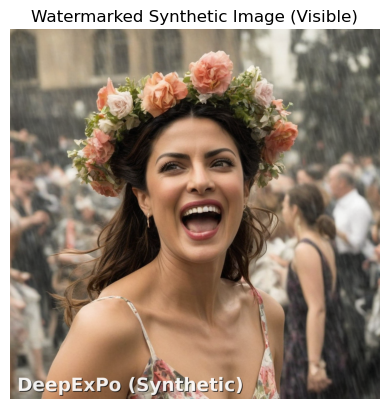

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Call the function and get the watermarked image
img = add_massive_watermark("/home/afgan_server/Important_Code/Watermakring/2/Picture6.png")

# Convert to numpy array and display
plt.imshow(np.array(img))
plt.axis('off')
plt.title("Watermarked Synthetic Image (Visible)")
plt.show()

In [15]:
import numpy as np
from PIL import Image
import torch

In [16]:
def load_image(path, size=(256, 256)):
    img = Image.open(path).convert("RGB").resize(size)
    img_np = np.array(img, dtype=np.float32) / 255.0
    img_chw = np.ascontiguousarray(img_np.transpose(2, 0, 1))  # ensure memory is contiguous
    return torch.tensor(img_chw, dtype=torch.float32)

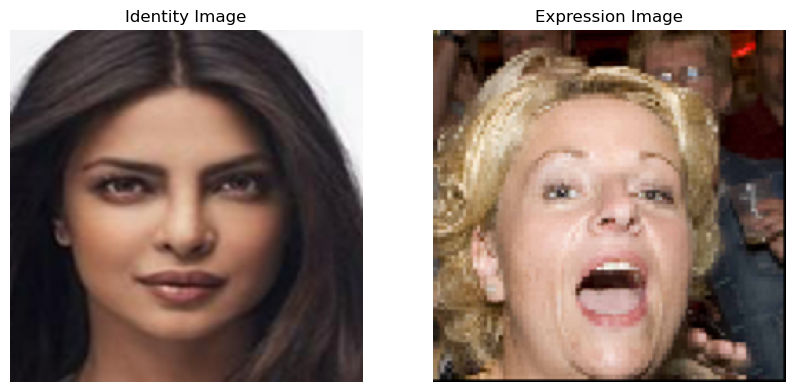

In [17]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Example: your images are PyTorch tensors [3, H, W], float32
identity_image = load_image("/home/afgan_server/Important_Code/Watermakring/2/Picture4.png")
expression_image = load_image("/home/afgan_server/Important_Code/Watermakring/2/Picture5.png")

# Convert to H x W x C and NumPy for matplotlib
identity_np = identity_image.permute(1, 2, 0).cpu().numpy()
expression_np = expression_image.permute(1, 2, 0).cpu().numpy()

# If images are float32 in [0,1], clip to [0,1] just in case
identity_np = np.clip(identity_np, 0, 1)
expression_np = np.clip(expression_np, 0, 1)

# Display side by side
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(identity_np)
plt.axis('off')
plt.title("Identity Image")

plt.subplot(1, 2, 2)
plt.imshow(expression_np)
plt.axis('off')
plt.title("Expression Image")

plt.show()

In [18]:
import hashlib
import json
from datetime import datetime

def get_identifier(image_tensor):
    # Convert tensor to bytes
    image_bytes = image_tensor.numpy().tobytes()
    # SHA256 hash
    return hashlib.sha256(image_bytes).hexdigest()

id_identifier = get_identifier(identity_image)
exp_identifier = get_identifier(expression_image)

print("Identity hash:", id_identifier)
print("Expression hash:", exp_identifier)

Identity hash: ff52e37b8b49da4d01bb82dbba44fa8ca161b8ca74cc7f8dbb31fa14b23272fe
Expression hash: 24f67acdcd8c78b9a0830bd30b92ae68387ac2eca1a1bddbe3cbef8e72bbe130


In [19]:
import hashlib
import json
from datetime import datetime

# Create combined metadata
timestamp = datetime.now().isoformat()
combined_metadata = json.dumps({
    "id_hash": id_identifier,
    "expression_hash": exp_identifier,
    "timestamp": timestamp
})

# Convert to integer payload for Stable Signature
payload_int = int(hashlib.sha256(combined_metadata.encode()).hexdigest()[:16], 16)

print("Payload int:", payload_int)

Payload int: 13749539826161590029


In [20]:
from PIL import Image
import numpy as np
import torch

def load_synthetic_image_highres(path):
    """
    Load a synthetic image from file as a PyTorch tensor in CHW format with values [0,1].
    Keeps the original image resolution.
    """
    # Load image with PIL (keep original resolution)
    img = Image.open(path).convert("RGB")
    
    # Convert to numpy array and normalize
    img_np = np.array(img, dtype=np.float32) / 255.0
    
    # Convert HWC -> CHW and ensure contiguous memory
    img_chw = np.ascontiguousarray(img_np.transpose(2, 0, 1))
    
    # Convert to torch tensor
    img_tensor = torch.tensor(img_chw, dtype=torch.float32)
    
    return img_tensor

# Load your synthetic image
synthetic_image_path = "/home/afgan_server/Important_Code/Watermakring/2/Picture6_watermarked.png"
synthetic_image = load_synthetic_image_highres(synthetic_image_path)

# Verify
print("Shape:", synthetic_image.shape)  # Should be [3, H, W], e.g., [3,1024,1024]
print("Dtype:", synthetic_image.dtype)  # Should be torch.float32
print("Min/Max values:", synthetic_image.min().item(), synthetic_image.max().item())  # 0-1

Shape: torch.Size([3, 1024, 1024])
Dtype: torch.float32
Min/Max values: 0.0 1.0


In [21]:
import torch
import numpy as np
from PIL import Image
import hashlib

class StableSignatureWatermarker:
    """
   Stable Signature watermarking implementation
    Embeds invisible watermarks in generated images
    """
    def __init__(self, strength=0.5, payload_bits=32):
        self.strength = strength
        self.payload_bits = payload_bits

    def _payload_to_binary(self, payload):
        binary = []
        for i in range(self.payload_bits):
            binary.append((payload >> i) & 1)
        return np.array(binary, dtype=np.float32)

    def _binary_to_payload(self, binary):
        payload = 0
        for i, bit in enumerate(binary):
            if bit > 0.5:
                payload |= (1 << i)
        return payload

    def embed(self, image: torch.Tensor, payload: int, strength=None):
        strength = strength or self.strength
        img = image.clone().detach()
        if img.max() > 1.5:
            img = img / 255.0
        if img.shape[0] in [3,4]:  # CHW
            img_np = img.permute(1,2,0).numpy()
        else:
            img_np = img.numpy()
        H, W = img_np.shape[:2]
        img_uint8 = (img_np*255).astype(np.uint8)
        img_pil = Image.fromarray(img_uint8).convert('YCbCr')
        img_ycbcr = np.array(img_pil, dtype=np.float32)/255.0
        binary_watermark = self._payload_to_binary(payload)
        watermark_map = np.zeros((H,W), dtype=np.float32)
        for i, bit in enumerate(binary_watermark):
            start_h = (i*H)//len(binary_watermark)
            end_h = ((i+1)*H)//len(binary_watermark)
            watermark_map[start_h:end_h, :] = bit
        img_ycbcr[:,:,0] = np.clip(img_ycbcr[:,:,0] + strength*0.05*(watermark_map-0.5), 0, 1)
        watermarked_uint8 = (img_ycbcr*255).astype(np.uint8)
        watermarked_pil = Image.fromarray(watermarked_uint8, 'YCbCr').convert('RGB')
        watermarked_np = np.array(watermarked_pil, dtype=np.float32)/255.0
        return torch.from_numpy(watermarked_np.transpose(2,0,1))

    def extract(self, image: torch.Tensor):
        img = image.clone().detach()
        if img.max() > 1.5:
            img = img / 255.0
        if img.shape[0] in [3,4]:
            img_np = img.permute(1,2,0).numpy()
        else:
            img_np = img.numpy()
        H,W = img_np.shape[:2]
        img_uint8 = (img_np*255).astype(np.uint8)
        img_pil = Image.fromarray(img_uint8).convert('YCbCr')
        img_ycbcr = np.array(img_pil, dtype=np.float32)/255.0
        luminance = img_ycbcr[:,:,0]
        extracted_binary = []
        for i in range(self.payload_bits):
            start_h = (i*H)//self.payload_bits
            end_h = ((i+1)*H)//self.payload_bits
            region_mean = luminance[start_h:end_h,:].mean()
            extracted_binary.append(1 if region_mean>0.5 else 0)
        extracted_binary = np.array(extracted_binary)
        payload = self._binary_to_payload(extracted_binary)
        confidence = 0.5
        return payload, confidence

In [22]:

# Initialize watermarking
watermarker = StableSignatureWatermarker(strength=1, payload_bits=64)
# Take lower 32 bits for reliable embedding in this notebook
payload_32 = payload_int & 0xFFFFFFFF
watermarked_image = watermarker.embed(synthetic_image, demo_payload, strength=0.5)

print("Watermark embedded successfully.")

Watermark embedded successfully.


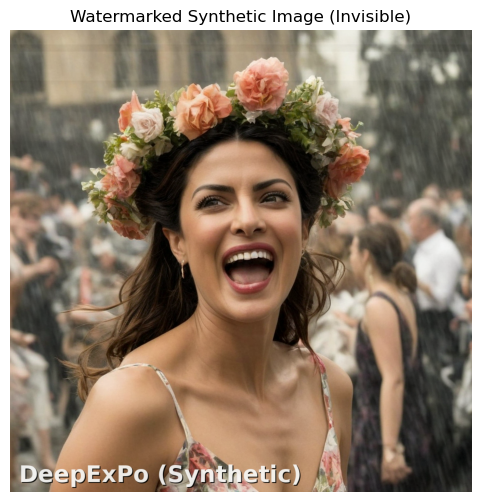

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Convert CHW -> HWC and clip to [0,1] for matplotlib
watermarked_np = watermarked_image.permute(1,2,0).numpy()
watermarked_np = np.clip(watermarked_np, 0, 1)

# Display inline
plt.figure(figsize=(6,6))
plt.imshow(watermarked_np)
plt.axis('off')
plt.title("Watermarked Synthetic Image (Invisible)")
plt.show()

In [24]:
from PIL import Image

# Convert to uint8 and save
watermarked_uint8 = (watermarked_np * 255).astype(np.uint8)
Image.fromarray(watermarked_uint8).save("/home/afgan_server/Important_Code/Watermakring/2/Picture6_watermarked(invisible).png")
print("✅ Invisible Watermarked image saved successfully.")

✅ Invisible Watermarked image saved successfully.


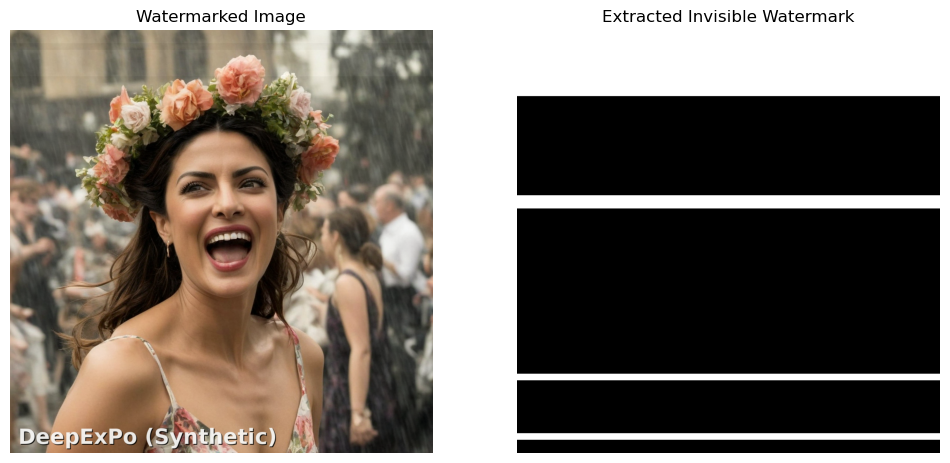

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Assume `watermarked_image` is your PyTorch tensor [3,H,W] ---
# --- Assume `watermarker` is already initialized with payload_bits etc. ---

def extract_watermark_as_image(watermarker, watermarked_image):
    """
    Extracts invisible watermark and returns it as a grayscale image.
    """
    img = watermarked_image.clone().detach()
    if img.max() > 1.5:
        img = img / 255.0
    
    # CHW -> HWC
    img_np = img.permute(1,2,0).numpy()
    H, W = img_np.shape[:2]
    
    # Convert to 8-bit and RGB -> YCbCr
    img_uint8 = (img_np*255).astype(np.uint8)
    img_pil = Image.fromarray(img_uint8).convert('YCbCr')
    img_ycbcr = np.array(img_pil, dtype=np.float32)/255.0
    luminance = img_ycbcr[:,:,0]  # Y channel
    
    # Reconstruct watermark map
    watermark_map = np.zeros((H,W), dtype=np.float32)
    for i in range(watermarker.payload_bits):
        start_h = (i*H)//watermarker.payload_bits
        end_h = ((i+1)*H)//watermarker.payload_bits
        region_mean = luminance[start_h:end_h,:].mean()
        bit = 1 if region_mean > 0.5 else 0
        watermark_map[start_h:end_h,:] = bit
    
    return watermark_map

# Extract watermark as image
watermark_image = extract_watermark_as_image(watermarker, watermarked_image)

# Convert watermarked image to HWC for plotting
watermarked_np = watermarked_image.permute(1,2,0).numpy()
watermarked_np = np.clip(watermarked_np, 0, 1)

# --- Display side by side ---
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(watermarked_np)
plt.axis('off')
plt.title("Watermarked Image")

plt.subplot(1,2,2)
plt.imshow(watermark_image, cmap='gray')
plt.axis('off')
plt.title("Extracted Invisible Watermark")

plt.show()

In [27]:
# Embed invisible watermark
watermarked_image = watermarker.embed(synthetic_image, payload_int, strength=0.5)

# Extract watermark
payload_extracted, confidence = watermarker.extract(watermarked_image)

print("Original payload:", payload_int)
print("Extracted payload:", payload_extracted)
print("Confidence:", confidence)

Original payload: 2725154325947573570
Extracted payload: 725154325947573568
Confidence: 0.98
